### Project Overview

##### Employee attrition is a persistent challenge in warehouse fulfilment centres, where demanding workloads, shift patterns, and management practices can impact retention.

This project analyses employee review data to:
- Identify key drivers of employee attrition
- Understand how employee sentiment differs between leavers and current employees
- Surface recurring operational pain points using natural language processing (NLP)

The analysis combines structured data (tenure, role, ratings) with unstructured text (employee reviews) to provide actionable, business-focused insights.

### Dataset Description

##### The dataset contains synthetic employee review data designed to reflect a real warehouse fulfilment environment.

Each row represents a single employee review and includes:
- Employee tenure (recorded in discrete month/year buckets)
- Employment status and role
- Multiple satisfaction ratings (culture, leadership, work-life balance, pay, career opportunities)
- Free-text feedback covering review summaries, pros, cons, and advice to management

The dataset includes both current and former employees, allowing attrition to be analysed explicitly.


In [ ]:
# Import libraries.
import pandas as pd

# Warnings.
import warnings
warnings.filterwarnings("ignore")


In [49]:
df = pd.read_csv(r"C:\Users\ADACHUKWU\OneDrive\Desktop\Github Repositories\employee-attrition-analysis\data\raw\Employee_feedback.csv")
df.head(2)

,employee_length,employee_status,employee_type,flags_business_outlook,flags_ceo_approval,flags_recommend_frend,rating_culture_values,rating_diversity_inclusion,rating_overall,rating_work_life,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,rating_compensation_benefits,rating_senior_leadership,rating_career_opportunities
0,2 years,regular,Ex employee,Yes,No,Yes,5,5,4,4,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,3,4,5
1,7 years,regular,Less than 2 years,No,Yes,Yes,3,4,4,5,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,4,4,3


#### Data Preparation & Quality Checks

Before analysis, several data quality checks were performed to ensure reliability:

- Verified dataset shape and column consistency
- Confirmed there were no duplicate rows
- Checked for missing or invalid values
- Ensured rating columns were within the expected 1–5 range

Employee attrition was defined using employment status, with former employees treated as attrition cases. The raw dataset was preserved, and analysis-specific subsets were created to maintain reproducibility.


In [19]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   employee_length               300 non-null    str  
 1   employee_status               300 non-null    str  
 2   employee_type                 300 non-null    str  
 3   flags_business_outlook        300 non-null    str  
 4   flags_ceo_approval            300 non-null    str  
 5   flags_recommend_frend         300 non-null    str  
 6   rating_culture_values         300 non-null    int64
 7   rating_diversity_inclusion    300 non-null    int64
 8   rating_overall                300 non-null    int64
 9   rating_work_life              300 non-null    int64
 10  review_summary                300 non-null    str  
 11  employee_location             300 non-null    str  
 12  employee_job_title            300 non-null    str  
 13  advice_to_management          300 non-null    

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating_culture_values,300.0,2.746667,1.472997,1.0,1.00,2.0,4.0,5.0
rating_diversity_inclusion,300.0,2.830000,1.474794,1.0,1.00,3.0,4.0,5.0
rating_overall,300.0,2.713333,1.399172,1.0,1.75,2.0,4.0,5.0
rating_work_life,300.0,2.826667,1.454996,1.0,1.75,3.0,4.0,5.0
rating_compensation_benefits,300.0,2.633333,1.432619,1.0,1.00,2.0,4.0,5.0
rating_senior_leadership,300.0,2.863333,1.355525,1.0,2.00,3.0,4.0,5.0
rating_career_opportunities,300.0,2.660000,1.500635,1.0,1.00,2.0,4.0,5.0


In [21]:
df.describe(include='object').T

,count,unique,top,freq
employee_length,300,10,2 years,36
employee_status,300,3,regular,203
employee_type,300,4,Current employee,143
flags_business_outlook,300,2,No,155
flags_ceo_approval,300,2,No,174
flags_recommend_frend,300,2,Yes,150
review_summary,300,300,"To be fair, promotions feel random; breaks fee...",1
employee_location,300,41,York,13
employee_job_title,300,3,Stower,111
advice_to_management,300,133,They should do task rotation to reduce strain.,12


In [22]:
df.shape

(300, 19)

In [23]:
df.isnull().sum()

employee_length                 0
employee_status                 0
employee_type                   0
flags_business_outlook          0
flags_ceo_approval              0
flags_recommend_frend           0
rating_culture_values           0
rating_diversity_inclusion      0
rating_overall                  0
rating_work_life                0
review_summary                  0
employee_location               0
employee_job_title              0
advice_to_management            0
review_pros                     0
review_cons                     0
rating_compensation_benefits    0
rating_senior_leadership        0
rating_career_opportunities     0
dtype: int64

In [53]:
df.columns

Index(['employee_length', 'employee_status', 'employee_type',
       'flags_business_outlook', 'flags_ceo_approval', 'flags_recommend_frend',
       'rating_culture_values', 'rating_diversity_inclusion', 'rating_overall',
       'rating_work_life', 'review_summary', 'employee_location',
       'employee_job_title', 'advice_to_management', 'review_pros',
       'review_cons', 'rating_compensation_benefits',
       'rating_senior_leadership', 'rating_career_opportunities'],
      dtype='str')

In [54]:
duplicates = int(df.duplicated().sum())
duplicates

0

In [55]:
df['employee_length'].value_counts()

employee_length
2 years     36
10 years    34
6 months    33
3 years     32
5 years     31
4 years     29
1 year      29
9 months    27
7 years     26
3 months    23
Name: count, dtype: int64

#### Feature Engineering

To support analysis and modelling, several derived features were created:

- **Attrition flag**: A binary indicator identifying former employees
- **Tenure bands**: Employee tenure was standardised and grouped into business-friendly bands:
  - < 1 year
  - 1–2 years
  - 2–5 years
  - 5+ years

These transformations allow attrition patterns to be analysed at a level that aligns with operational decision-making.


In [56]:
# Function that categorises length of employment into buckets.
def assign_tenure(tenure):
    number = int(tenure.split()[0])
    
    # Convert tenure to months
    if "month" in tenure:
        months = number
    elif "year" in tenure:
        months = number * 12
    else:
        return "unknown"
    
    # Assign tenure band
    if months < 12:
        return "less than 1 year"
    elif months < 24:
        return "1-2 years"
    elif months < 60:
        return "2-5 years"
    else:
        return "5+ years"

In [57]:
df["tenure"] = df["employee_length"].apply(assign_tenure)

In [58]:
df.head(2)

,employee_length,employee_status,employee_type,flags_business_outlook,flags_ceo_approval,flags_recommend_frend,rating_culture_values,rating_diversity_inclusion,rating_overall,rating_work_life,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,rating_compensation_benefits,rating_senior_leadership,rating_career_opportunities,tenure
0,2 years,regular,Ex employee,Yes,No,Yes,5,5,4,4,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,3,4,5,2-5 years
1,7 years,regular,Less than 2 years,No,Yes,Yes,3,4,4,5,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,4,4,3,5+ years


In [59]:
df["tenure"].value_counts()

tenure
2-5 years           97
5+ years            91
less than 1 year    83
1-2 years           29
Name: count, dtype: int64

#### Text Cleaning & NLP Preparation

Employee review text required preprocessing before analysis. A reusable text-cleaning function was implemented to:

- Convert text to lowercase
- Remove punctuation, numbers, and non-alphabetic characters
- Remove standard English stopwords
- Remove domain-specific stopwords (e.g. generic workplace terms)
- Handle missing values safely

This ensured that downstream NLP analysis focused on meaningful language rather than noise.


In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
from wordcloud import WordCloud
from textblob import TextBlob
import re 

# One-time downloads (run once)
nltk.download("stopwords")
nltk.download("punkt")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADACHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADACHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Create dataframe containing relevant columns.
df_sentiment = df[["employee_status", "review_summary", "employee_location", "employee_job_title", "advice_to_management", "review_pros", "review_cons", "tenure"]].copy()
df_sentiment.head(5)

,employee_status,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,tenure
0,regular,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,2-5 years
1,regular,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,5+ years
2,part time,"Tbh, pay is competitive; non-stop work; favour...",Stoke-on-Trent,Forklift Operator,Please improve break planning and support new...,"good friendly coworkers, overtime available is...",Cons: too much managment communication,2-5 years
3,regular,"Tbh, proper PPE, and site feels cold, and work...",Bolton,Stower,They should support new starters more.,"clean site, good shifts can fit students, easy...",long shifts,2-5 years
4,regular,"Honestly, overtime helps; few chances to move ...",Norwich,Stower,Priority: train supervisors better.,"overtime available is a plus, good friendly co...","Cons: short breaks, too much short staffed, po...",5+ years


In [91]:
sw = set(stopwords.words("english"))
stop_keywords = {'ok', 'id', 'wouldnt', 'days', 'day', 'tbh', 'site', 'feel', 'much'}
custom_stopwords = sw.union(stop_keywords)

In [92]:
# Create function to clean dataset.
def clean_text(text):
    if pd.isnull(text):
        return ""
    # Convert to string and lowercase
    text = str(text).lower()

    text = re.sub(r"[^a-z\s]", "", text)


    # Remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_stopwords]

    return " ".join(tokens)

In [93]:
# List the columns to clean.
text_cols = ['review_summary', 'advice_to_management']

for col in text_cols:
    df_sentiment[f'cleaned_{col}'] = df_sentiment[col].apply(clean_text)

In [94]:
df_sentiment.head(5)

,employee_status,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,tenure,cleaned_review_summary,cleaned_advice_to_management
0,regular,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,2-5 years,fair promotions random breaks short worst best,priority sort rota notice
1,regular,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,5+ years,nonstop work benefits weak development limited...,please sort rota notice lower unrealistic targets
2,part time,"Tbh, pay is competitive; non-stop work; favour...",Stoke-on-Trent,Forklift Operator,Please improve break planning and support new...,"good friendly coworkers, overtime available is...",Cons: too much managment communication,2-5 years,pay competitive nonstop work favouritism rotas...,please improve break planning support new star...
3,regular,"Tbh, proper PPE, and site feels cold, and work...",Bolton,Stower,They should support new starters more.,"clean site, good shifts can fit students, easy...",long shifts,2-5 years,proper ppe feels cold workload heavy training ...,support new starters
4,regular,"Honestly, overtime helps; few chances to move ...",Norwich,Stower,Priority: train supervisors better.,"overtime available is a plus, good friendly co...","Cons: short breaks, too much short staffed, po...",5+ years,honestly overtime helps chances move rotas cha...,priority train supervisors better


#### Keyword & Theme Analysis

After cleaning, keyword frequency analysis was performed to identify recurring themes across employee reviews.

Unigram analysis highlighted common topics related to:
- Workload and shift demands
- Management and communication
- Operational pressure during peak periods

These results provide an initial, data-driven view of the issues most frequently raised by employees.

In [95]:
# Tokenize Text into Words.
# Join all column into one big string, then split into words.
all_words = ' '.join(df_sentiment['cleaned_review_summary']).split()

In [96]:
# To determine the frequency of Keywords.
word_counts = Counter(all_words)
word_counts.most_common(20) 

[('good', 96),
 ('pay', 95),
 ('short', 58),
 ('training', 57),
 ('recommend', 55),
 ('decent', 45),
 ('long', 42),
 ('fair', 37),
 ('worst', 36),
 ('best', 36),
 ('someone', 36),
 ('tough', 36),
 ('people', 36),
 ('shifts', 36),
 ('gonna', 36),
 ('lie', 36),
 ('stint', 33),
 ('one', 33),
 ('shift', 32),
 ('safety', 31)]

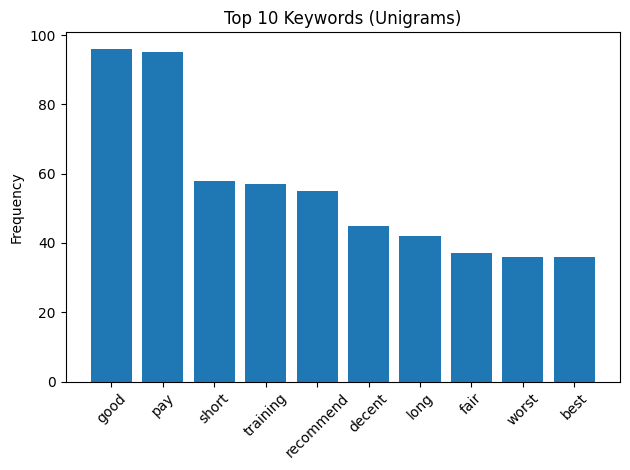

In [99]:
# Visualise keywords using graphs and charts.
most_common = word_counts.most_common(10)
words, counts = zip(*most_common)

plt.bar(words, counts)
plt.title("Top 10 Keywords (Unigrams)")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [100]:
bigrams = list(ngrams(all_words, 2))
trigrams = list(ngrams(all_words, 3))

bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

In [101]:
bigram_counts.most_common(10)

[(('worst', 'best'), 36),
 (('someone', 'tough'), 36),
 (('gonna', 'lie'), 36),
 (('good', 'short'), 33),
 (('short', 'stint'), 33),
 (('development', 'limited'), 30),
 (('recommend', 'someone'), 30),
 (('decent', 'stressful'), 30),
 (('im', 'real'), 29),
 (('long', 'term'), 29)]

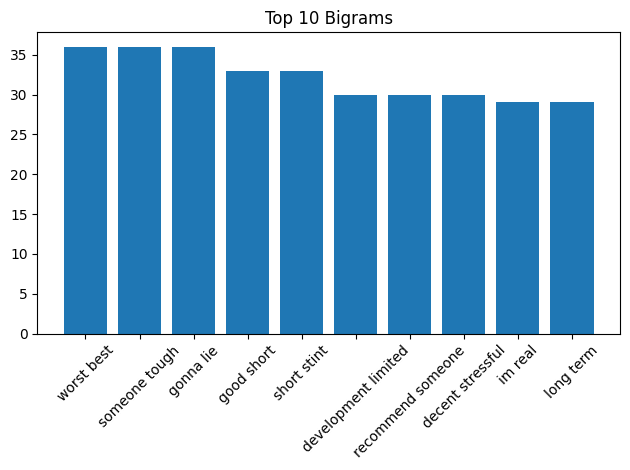

In [103]:
common_bigrams = bigram_counts.most_common(10)
bg_labels = [' '.join(bg) for bg, count in common_bigrams]
bg_counts = [count for bg, count in common_bigrams]

plt.bar(bg_labels, bg_counts)
plt.title("Top 10 Bigrams")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [102]:
trigram_counts.most_common(10)

[(('good', 'short', 'stint'), 33),
 (('recommend', 'someone', 'tough'), 30),
 (('could', 'good', 'better'), 28),
 (('need', 'quick', 'money'), 28),
 (('career', 'path', 'unclear'), 25),
 (('toxic', 'vibe', 'sometimes'), 25),
 (('recommend', 'long', 'term'), 25),
 (('stay', 'fixed', 'basics'), 24),
 (('managers', 'dont', 'listen'), 24),
 (('pay', 'doesnt', 'match'), 22)]

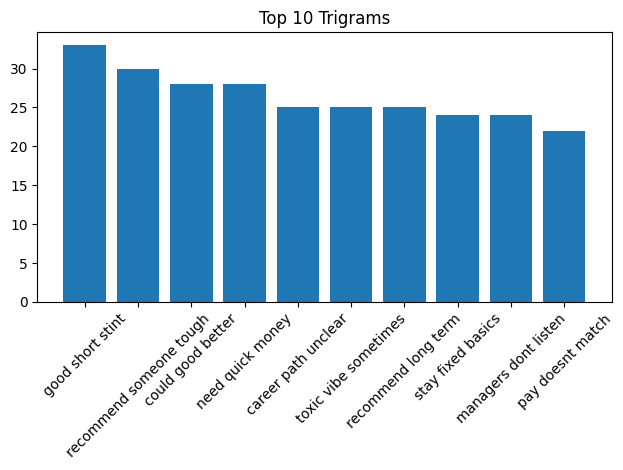

In [104]:
common_trigrams = trigram_counts.most_common(10)
tg_labels = [' '.join(tg) for tg, count in common_trigrams]
tg_counts = [count for tg, count in common_trigrams]

plt.bar(tg_labels, tg_counts)
plt.title("Top 10 Trigrams")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

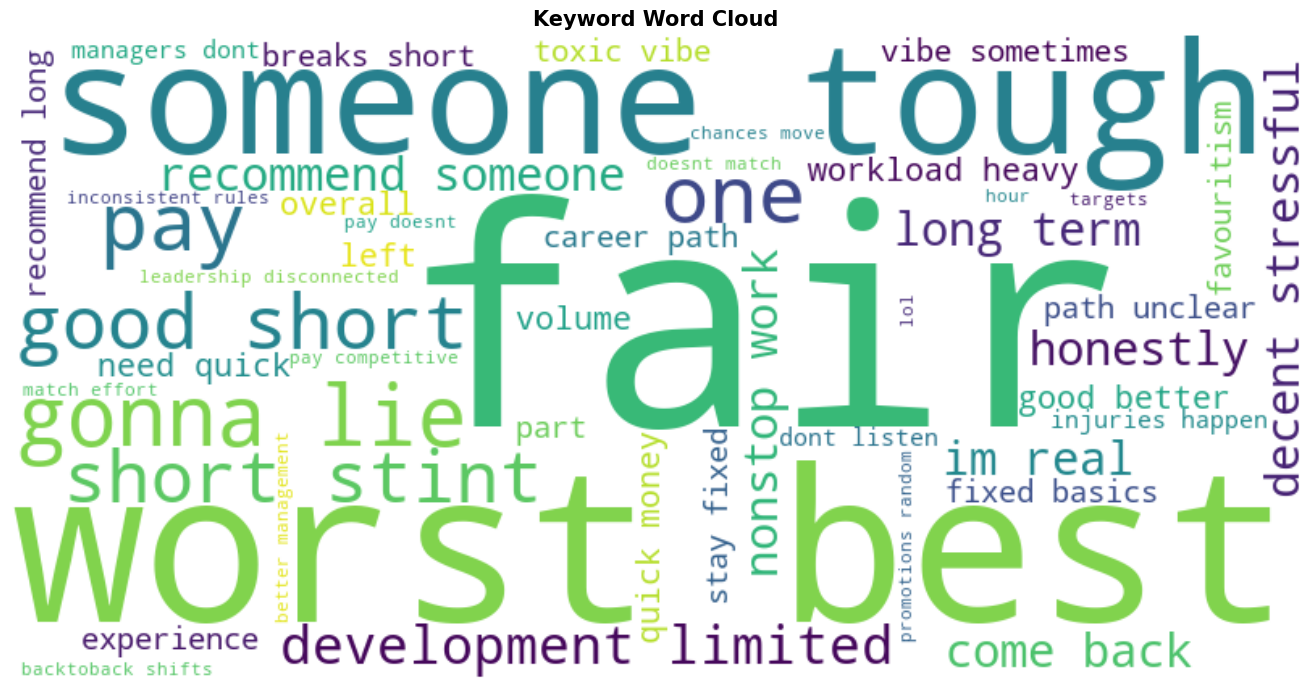

In [108]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=50,
    relative_scaling=0.5,
    min_font_size=10
    ).generate(' '.join(all_words))

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Keyword Word Cloud", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

#### Sentiment Analysis

Sentiment analysis was conducted using TextBlob to quantify the emotional tone of employee feedback.

Each review was assigned a polarity score, allowing sentiment to be compared:
- Between current and former employees
- Across tenure bands and job roles

This step helped connect qualitative feedback with measurable attrition risk, providing a clearer picture of how dissatisfaction translates into employee exits.


In [111]:
# Score each employee review in terms of facts, opinion, and sentiment.

df_sentiment['sentiment_polarity'] = df_sentiment['cleaned_review_summary'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_sentiment['sentiment_subjectivity'] = df_sentiment['cleaned_review_summary'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [120]:
df_sentiment.head(2)

,employee_status,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,tenure,cleaned_review_summary,cleaned_advice_to_management,sentiment_polarity,sentiment_subjectivity
0,regular,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,2-5 years,fair promotions random breaks short worst best,priority sort rota notice,0.040000,0.600000
1,regular,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,5+ years,nonstop work benefits weak development limited...,please sort rota notice lower unrealistic targets,-0.283829,0.500298


In [121]:
# Create Sentiment Labels.
def label_sentiment(score):
  if score > 0.1:
    return 'positive'
  elif score < -0.1:
    return 'negative'
  else:
    return 'neutral'

df_sentiment['sentiment_label'] = df_sentiment['sentiment_polarity'].apply(label_sentiment)

In [122]:
df_sentiment.head(2)

,employee_status,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,tenure,cleaned_review_summary,cleaned_advice_to_management,sentiment_polarity,sentiment_subjectivity,sentiment_label
0,regular,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,2-5 years,fair promotions random breaks short worst best,priority sort rota notice,0.040000,0.600000,neutral
1,regular,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,5+ years,nonstop work benefits weak development limited...,please sort rota notice lower unrealistic targets,-0.283829,0.500298,negative


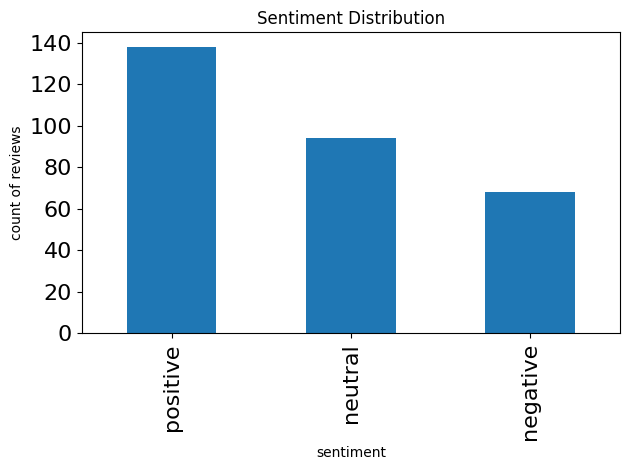

In [123]:
# Visualising the sentiment distribution.

df_sentiment['sentiment_label'].value_counts().plot(
    kind='bar', title='Sentiment Distribution', fontsize=16
)
plt.xlabel("sentiment")
plt.ylabel('count of reviews')
plt.tight_layout()
plt.show()